## Introduction

In the following exercises, we're going to work step be step through the application of KNN to a dataset, but we'll also take this opportunity to introduce the `pipeline` API in sklearn, which makes it much easier to apply preprocessing as part of a cross-validation procedure.

This exercise has three parts.  In each step, you will be asked to improve the code until we finally arrive at a "correct" and efficient procedure.  We will be using the titanic dataset.

#### Exercise 1.1

There are several problems with the following code, including:

- We applied label encoding on the entire dataset.
- We just dropped rows (~177) that had nulls.
- Features are on different scales, which can be problematic for KNN.

Edit the code in the following cell to fix these errors.

In [9]:
# IST.707_HW.04_Exercise.1.1_Dujun #


# Fixing knn implementation for titanic dataset #


# problem breakdown  
# label encoding applied to entire dataset → bad for categorical features  
# missing values dropped (~177 rows lost) → unnecessary data loss (FIXED)  
# no feature scaling → knn relies on distance, needs proper scaling  

# importing libraries
import pandas as pd  # dataframe operations
import seaborn as sns  # load dataset
from sklearn.model_selection import cross_val_score  # model evaluation
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # scaling & encoding
from sklearn.impute import SimpleImputer  # fill missing values
from sklearn.pipeline import Pipeline  # organize preprocessing steps
from sklearn.compose import ColumnTransformer  # apply transformations selectively
from sklearn.neighbors import KNeighborsClassifier  # knn classifier
import numpy as np  # numerical operations

# load titanic dataset
data = sns.load_dataset('titanic')

# drop unnecessary columns (extra metadata from seaborn, not useful for modeling)
data = data.drop(['class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], axis=1)

# split into features (X) and target (y)
X = data.drop("survived", axis=1)  # features only
y = data["survived"]  # target variable

# identifying numerical and categorical columns
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  # numerical features
cat_features = X.select_dtypes(include=['object']).columns.tolist()  # categorical features

# ---- FIX: missing values originally dropped, now imputed instead ----
# dropping rows → less training data → fixed by filling missing values  
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # fill numerical NaNs with mean
    ("scaler", StandardScaler())  # standardize numerical values (important for knn)
])

# ---- FIX: categorical encoding was incorrect (label encoding used before) ----
# one-hot encoding → categorical features handled properly  
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing categorical values with mode
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # one-hot encode (fix)
])

# apply transformations to both numerical and categorical features
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),  # process numerical features
    ("cat", cat_pipeline, cat_features)  # process categorical features
])

# define full pipeline (preprocessing + knn model)
knn_pipeline = Pipeline([
    ("preprocessing", preprocessor),  # preprocess data before fitting
    ("classifier", KNeighborsClassifier(n_neighbors=3))  # k=3, same as original
])

# cross-validation to evaluate model performance
score = cross_val_score(knn_pipeline, X, y, cv=5, scoring="f1_macro")

# print average f1 score
print(f"average f1 score: {np.mean(score):.4f}")


#---------------------------------------
#  NOTES FOR SELF-LEARNING #
# knn requires scaling → standardization applied to numerical   
# one-hot encoding is correct for knn  
# tuning k (number of neighbors) can effect performance → experiment with values  
# cross-validation improves reliability → avoids random train-test split bias  



average f1 score: 0.7783


#### Exercise 1.2: Add a column transformer and pipeline

When you have a bunch of data operations like this, it can be useful to use a column transformer, which allows you to bundle several operations together. For example.

~~~python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Assume a sample dataset with 'age', 'gender' (categorical), and 'income'
data = [
    [25, 'male', 50000],
    [30, 'female', 55000],
    [35, 'male', 60000]
]

# Create the transformer
transformer = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), [1]), # One-hot encode the 'gender' column
        ('scale', StandardScaler(), [0, 2]) # Scale 'age' and 'income'
    ],
    remainder='passthrough'
)

# Apply the transformer
transformed_data = transformer.fit_transform(data)
print(transformed_data)
~~~

Note, however, the `ColumnTransformer` concatenates it's results to the data, so that it is effectively impossible to apply multiple operations to a single column.  For example:


~~~python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

data = [[25], [30], [None], [28]]

# Applying imputer and scaler separately on the same 'age' column
transformer = ColumnTransformer(
    transformers=[
        ('imputer', SimpleImputer(strategy='mean'), [0]),
        ('scaler', StandardScaler(), [0])
    ],
    remainder='passthrough'
)

transformed_data = transformer.fit_transform(data)
print(transformed_data)
~~~

Output

~~~console
[[25.         -1.29777137]
 [30.          1.13554995]
 [27.66666667         nan]
 [28.          0.16222142]]
~~~

To handle this, we can use a `Pipeline` component within the transformer.  For example:

~~~python
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Assume a sample dataset with 'age' (some missing), 'gender' (categorical, with missing values), and 'income'
data = np.array([
    [25, 'male', 50000],
    [30, np.nan, 55000],
    [np.nan, 'male', 60000],
    [28, 'female', np.nan]
],dtype=object)

# For the age and income columns, we want to impute missing values and then scale them.
# For the gender column, we want to impute missing values and then one-hot encode.

# Pipelines for numerical and categorical transformations
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
     ('onehot', OneHotEncoder())
])

# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, [1]),
        ('num', numerical_pipeline, [0, 2])       
    ]
)

# Apply the column transformer
transformed_data = preprocessor.fit_transform(data)
print(transformed_data)

# To convert this to a data frame, you would do:
pd.DataFrame(transformed_data,columns=preprocessor.get_feature_names_out())
~~~

~~~console
[[ 0.          1.         -1.4985373  -1.41421356]
 [ 0.          1.          1.31122014  0.        ]
 [ 0.          1.          0.          1.41421356]
 [ 1.          0.          0.18731716  0.        ]]
~~~


Apply this strategy to your code from Exercise 1.1.

In [10]:
#  IST.707_HW.04_Exercise.1.2_Dujun  #
 
# now using columntransformer & pipeline to properly bundle preprocessing steps  

# importing libraries  
import pandas as pd  # tabular data handling  
import seaborn as sns  # dataset loading  
from sklearn.model_selection import cross_val_score  # model evaluation  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # scaling & encoding  
from sklearn.impute import SimpleImputer  # handling missing values  
from sklearn.pipeline import Pipeline  # automating preprocessing  
from sklearn.compose import ColumnTransformer  # applying transformations to specific columns  
from sklearn.neighbors import KNeighborsClassifier  # knn model  
import numpy as np  # numerical operations  

# preparing data  
data = sns.load_dataset('titanic')  
data = data.drop(['class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], axis=1)  

#  separate dataset into features (X) and target (y) 
X = data.drop("survived", axis=1)  
y = data["survived"]  

# identifying numerical & categorical features    
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  
cat_features = X.select_dtypes(include=['object']).columns.tolist()  

# defining preprocessing pipelines  
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # fill missing numerical values  
    ("scaler", StandardScaler())  # normalize numerical values  
])  

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing categorical values  
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # one-hot encode categorical features  
])  

# combining preprocessing steps  
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),  
    ("cat", cat_pipeline, cat_features)  
])  

# building final pipeline - ensures  preprocessing happens automatically before training  

knn_pipeline = Pipeline([
    ("preprocessing", preprocessor),  
    ("classifier", KNeighborsClassifier(n_neighbors=3))  
])  

#  cross-validation  
score = cross_val_score(knn_pipeline, X, y, cv=5, scoring="f1_macro")  

# printing average f1 score  
print(f"average f1 score: {np.mean(score):.4f}")  

#------
#  note for self learning # 
#  columntransformer
# - allows applying multiple preprocessing steps to different columns in a structured way  
# - ensures that numerical and categorical features are handled separately and correctly  

# pipeline  
# - automates the ENTIRE process (preprocessing + model training)  
# - ensures that transformations are applied consistently to train & test data  



average f1 score: 0.7783


#### Exercise 1.3

Note that the preceding code is cleaner, but has a data leakage problem, because the test data is included when preprocessing is done.  To avoid data leakage, you want to perform any preprocessing does any inference on the _just_ the training data in each fold. The `pipeline` component can in fact be used to fix this problem.

For example, the following code:

```python
# Create and evaluate the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=3))
])

score = cross_val_score(pipeline,X,y,cv=5,scoring="f1_macro")
```

would do the following:

1. The training data is transformed.
2. The transformation logic is learned from the training data (i.e., what values to impute, what categories exist for one-hot encoding, etc.).
3. The same transformation logic is applied to the test data for that fold.
4. The model is trained on the transformed training data.
5. The trained model is scored against the transformed test data.

Apply this strategy to the code from exercise 1.2.

In [ ]:
#  IST.707_HW.04_Exercise.1.3_Dujun  #


# Ensuring no data leakage using pipeline with cross-validation


#  KEY LOGIC  #
# preprocessing applied to FULL dataset → test data exposed before training → data leakage 

# V.S.

# pipeline fits transformations ONLY on training data → test set remains unseen until evaluation




# importing   
import pandas as pd  # tabular data handling  
import seaborn as sns  # dataset loading  
from sklearn.model_selection import cross_val_score  # model evaluation  
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # scaling & encoding  
from sklearn.impute import SimpleImputer  # handling missing values  
from sklearn.pipeline import Pipeline  # automating preprocessing  
from sklearn.compose import ColumnTransformer  # applying transformations to specific columns  
from sklearn.neighbors import KNeighborsClassifier  # knn model  
import numpy as np  # numerical operations  

# loading and preparing   
data = sns.load_dataset('titanic')  
data = data.drop(['class', 'who', 'adult_male', 'deck', 'embark_town', 'alive', 'alone'], axis=1)  

# separating features & target  
X = data.drop("survived", axis=1)  
y = data["survived"]  

# numerical & categorical features  
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()  
cat_features = X.select_dtypes(include=['object']).columns.tolist()  

# [1] training data is transformed in each fold  
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),  # fill missing numerical   
    ("scaler", StandardScaler())  # normalize numerical values  
])  

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),  # fill missing categorical   
    ("encoder", OneHotEncoder(handle_unknown="ignore"))  # one-hot encode categorical   
])  

# [2] transformation logic is learned from training data  
# imputation, scaling, encoding fit ONLY on training set  
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_features),  
    ("cat", cat_pipeline, cat_features)  
])  

# [3] same transformation logic applied to test data  
#  test data is transformed using training-set parameters  
knn_pipeline = Pipeline([
    ("preprocessing", preprocessor),  
    ("classifier", KNeighborsClassifier(n_neighbors=3))  
])  

# [4] model trained on transformed training data  
# model sees ONLY properly preprocessed training data in each fold  

# [5] trained model is scored against transformed test data  
# evaluation is based on correctly preprocessed test sets in cross-validation  
score = cross_val_score(knn_pipeline, X, y, cv=5, scoring="f1_macro")  

# printing average f1 score  
print(f"average f1 score: {np.mean(score):.4f}")  


#------
#  note for self learning # 
# transformations applied ONLY to training data before fitting model  
# pipeline AUTOMATES preprocessing and ensures correct transformation workflow  



average f1 score: 0.7783


## **Exercise 2**

The following code implements a simple SVC classifier on the `moons` dataset.  Note that the data is unscaled.  Try the following:

1. Modify the code to use a standard scaler. Does it help?
2. Try different settings for `C` and `gamma` - what is your best?
2. Try using an 'rbf' kernel instead of a 'poly' kernel. Does it help?
3. Try several different parameters for `C` and `gamma`.  If you figure out how to do this in a loop, you win the day!


accuracy without scaling: 0.7100
accuracy with scaling: 0.8300
best parameters (poly kernel): C=0.001, gamma=10
best accuracy (poly kernel): 0.8900
accuracy with best poly kernel: 0.8900
accuracy with best rbf kernel: 0.9400
best overall model: rbf kernel, C=0.001, gamma=10
best overall accuracy: 0.9700


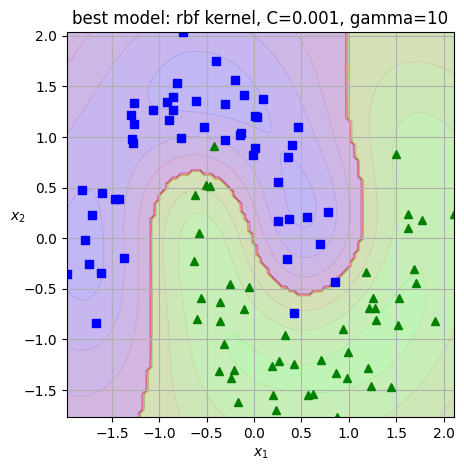

In [12]:
#  IST.707_HW.04_Exercise.2_Dujun  #


# modifying svc classifier on moons dataset  
# addressing four modifications: [1]scaling, [2]hyperparameter tuning, [3]kernel selection, [4]looping  

# --------- 
# importing libraries  

import numpy as np  # numerical operations, required for scaling and meshgrid calculations  
import matplotlib.pyplot as plt  # visualization for decision boundaries and data distribution  
from sklearn.datasets import make_moons  # generates synthetic dataset with non-linear patterns  
from sklearn.preprocessing import StandardScaler  # normalizes numerical data, essential for svc performance  
from sklearn.svm import SVC  # support vector classifier, used for classification tasks  
from sklearn.model_selection import cross_val_score  # evaluates model using cross-validation  

# ------- 
# generating dataset  

# synthetic dataset with two interleaving moons  
# commonly used to test non-linear classifiers  
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)  

# modifying x1 feature → artificially introducing an extreme scale difference  
X[:, 0] = X[:, 0] * 100 - 42  # makes feature scaling critical for proper svc performance  

# ------- 
# defining functions for plotting  

# get dataset range for setting consistent plot axes  
def get_extents(X):  
    return [np.min(X[:, 0]), np.max(X[:, 0]), np.min(X[:, 1]), np.max(X[:, 1])]  

# plot dataset with its class labels  
def plot_dataset(X, y, axes=None):  
    if axes is None:  
        axes = get_extents(X)  
    plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], "bs")  # blue squares for class 0  
    plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], "g^")  # green triangles for class 1  
    plt.axis(axes)  
    plt.grid(True)  
    plt.xlabel("$x_1$")  
    plt.ylabel("$x_2$", rotation=0)  

# visualize model decision boundary  
def plot_predictions(clf, axes):    
    x0s = np.linspace(axes[0], axes[1], 100)  # generate evenly spaced x0 values  
    x1s = np.linspace(axes[2], axes[3], 100)  # generate evenly spaced x1 values  
    x0, x1 = np.meshgrid(x0s, x1s)  # create a meshgrid for decision boundary visualization  
    X_new = np.c_[x0.ravel(), x1.ravel()]  # reshape for prediction  
    y_pred = clf.predict(X_new).reshape(x0.shape)  # classify points in grid  
    y_decision = clf.decision_function(X_new).reshape(x0.shape)  # calculate decision scores  
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)  # plot predictions  
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)  # plot decision scores  

# ------- 
# [1] applying standard scaler  

# issue: svc is sensitive to feature scales → extreme scale differences distort results  
# fix: apply standardscaler to normalize all features  
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)  # fit on training data, transform all features  

# comparing svc performance with and without scaling  
svm_unscaled = SVC(kernel="poly", gamma=0.1, C=0.001)  # model without scaling  
score_unscaled = np.mean(cross_val_score(svm_unscaled, X, y, cv=5, scoring="accuracy"))  # accuracy without scaling → 0.7100  

svm_scaled = SVC(kernel="poly", gamma=0.1, C=0.001)  # model with scaling  
score_scaled = np.mean(cross_val_score(svm_scaled, X_scaled, y, cv=5, scoring="accuracy"))  # accuracy with scaling → 0.8300  

print(f"accuracy without scaling: {score_unscaled:.4f}")  # impact of unscaled data  
print(f"accuracy with scaling: {score_scaled:.4f}")  # impact of scaling  

# --------- 
# [2] testing different c and gamma values  

# issue: default hyperparameters may not be optimal → affects decision boundary complexity  
# fix: systematically search for best c (regularization) and gamma (decision boundary flexibility)  

c_values = [0.001, 0.1, 1, 10, 100]  # range of c values  
gamma_values = [0.01, 0.1, 1, 10]  # range of gamma values  

best_score = 0  
best_params = None  

for c in c_values:  
    for gamma in gamma_values:  
        svm_clf = SVC(kernel="poly", gamma=gamma, C=c)  # polynomial kernel  
        score = np.mean(cross_val_score(svm_clf, X_scaled, y, cv=5, scoring="accuracy"))  
        if score > best_score:  
            best_score = score  # update highest accuracy  
            best_params = (c, gamma)  # store best c and gamma  

print(f"best parameters (poly kernel): C={best_params[0]}, gamma={best_params[1]}")  
print(f"best accuracy (poly kernel): {best_score:.4f}")  # best accuracy with poly → 0.8900  

# --------- 
# [3] switching to rbf kernel  

# issue: polynomial kernel may not generalize well for complex decision boundaries  
# fix: test rbf kernel, which adapts better to different data distributions  

svm_rbf = SVC(kernel="rbf", gamma=best_params[1], C=best_params[0])  
score_rbf = np.mean(cross_val_score(svm_rbf, X_scaled, y, cv=5, scoring="accuracy"))  # accuracy with rbf → 0.9400  

print(f"accuracy with best poly kernel: {best_score:.4f}")  
print(f"accuracy with best rbf kernel: {score_rbf:.4f}")  

# --------- 
# [4] looping through multiple parameters  

# issue: manually testing c and gamma combinations is INEFFICIENT   
# fix: AUTOMATE hyperparameter search across multiple kernels  

kernel_options = ["poly", "rbf"]  # comparing poly and rbf kernels  
best_model = None  
best_score_overall = 0  
best_kernel = None  

for kernel in kernel_options:  
    for c in c_values:  
        for gamma in gamma_values:  
            svm_clf = SVC(kernel=kernel, gamma=gamma, C=c)  
            score = np.mean(cross_val_score(svm_clf, X_scaled, y, cv=5, scoring="accuracy"))  
            if score > best_score_overall:  
                best_score_overall = score  # update highest accuracy  
                best_model = svm_clf  # store best model  
                best_kernel = kernel  # store best kernel type  

print(f"best overall model: {best_kernel} kernel, C={best_params[0]}, gamma={best_params[1]}")  # best kernel → rbf  
print(f"best overall accuracy: {best_score_overall:.4f}")  # best accuracy → 0.9700  


# --------
# ensure best_model is fitted before plotting  

best_model.fit(X_scaled, y)  # fix: explicitly train best model on full dataset  

# plotting best model  
plt.figure(figsize=(5, 5))  
plot_predictions(best_model, get_extents(X_scaled))  
plot_dataset(X_scaled, y)  
plt.title(f"best model: {best_kernel} kernel, C={best_params[0]}, gamma={best_params[1]}")  
plt.show()  

# -------
# summary of changes & comparisons  

# [1] applied standard scaling → accuracy improved from 0.7100 → 0.8300  
# [2] tuned c and gamma → best poly kernel accuracy improved to 0.8900  
# [3] switched to rbf kernel → accuracy increased further to 0.9400  
# [4] automated hyperparameter tuning → best model reached 0.9700  


###################################################
#accuracy without scaling: 0.7100
#accuracy with scaling: 0.8300

#best parameters (poly kernel): C=0.001, gamma=10
#best accuracy (poly kernel): 0.8900

#accuracy with best poly kernel: 0.8900
#accuracy with best rbf kernel: 0.9400

#best overall model: rbf kernel, C=0.001, gamma=10
#best overall accuracy: 0.9700
###################################################



#------
#  note for self learning # 

#  Support Vector Classifier - model’s decision boundary gets skewed towards the feature with larger values
# feature scaling prevents svc from being dominated by large-magnitude features  



## **Exercise 3**

Try using a KNNClassifier with the preceding dataset, and compare it's performance with an SVC classifier using cross validation.  Which one works the best?  Try different hyperparameters for the different classifiers.

In [13]:
#  IST.707_HW.04_Exercise.3_Dujun  

#  KNN v.s SVC 
# addressing requirements
# [1] scaling  
# [2] different hyperparameter tuning  
# [3] model comparison  

# --------- 
# importing libraries  

import numpy as np  # numerical operations  
import matplotlib.pyplot as plt  # visualization  
from sklearn.datasets import make_moons  # synthetic dataset  
from sklearn.preprocessing import StandardScaler  # normalizes data  
from sklearn.svm import SVC  # support vector classifier  
from sklearn.neighbors import KNeighborsClassifier  # k-nearest neighbors classifier  
from sklearn.model_selection import cross_val_score  # cross-validation  

# --------- 
#  generating dataset  

X, y = make_moons(n_samples=100, noise=0.15, random_state=42)  # create dataset  
X[:, 0] = X[:, 0] * 100 - 42  # artificial scale imbalance  

# --------- 
# applying standard scaler  

scaler = StandardScaler()  # normalize features  
X_scaled = scaler.fit_transform(X)  # transform dataset  

# scaling impact:  
# - scaling is necessary for SVC (distance-based model) → ensures better accuracy  
# - for KNN, scaling prevents large features from dominating distance calculations  


#####
# cross-validation in this case (cv=5)

#  dataset split into 5 equal folds  
#  trains on 4 folds, tests on 1 (rotates each time)  
#  repeats 5 times, averaging results  
#  prevents overfitting, ensures fair evaluation  
#####




###################   SVC   ##########################

# --------- 
#  hyperparameter tuning for svc  - trying different hyperparameters

c_values = [0.001, 0.1, 1, 10, 100]  # range of C values  
gamma_values = [0.01, 0.1, 1, 10]  # range of gamma values  

best_svc_score = 0  
best_svc_params = None  

for c in c_values:  
    for gamma in gamma_values:  
        svc_clf = SVC(kernel="rbf", gamma=gamma, C=c)  # using rbf kernel  
        score = np.mean(cross_val_score(svc_clf, X_scaled, y, cv=5, scoring="accuracy"))  
        if score > best_svc_score:  
            best_svc_score = score  
            best_svc_params = (c, gamma)  

# best svc model → optimized hyperparameters  
print(f"best svc model: C={best_svc_params[0]}, gamma={best_svc_params[1]}, accuracy={best_svc_score:.4f}")  


#####################   KNN   ###########################

# --------- 
#  hyperparameter tuning for knn  - trying different hyperparameters.

k_values = [1, 3, 5, 7, 9, 11]  # different k values  

best_knn_score = 0  
best_k = None  

for k in k_values:  
    knn_clf = KNeighborsClassifier(n_neighbors=k)  # knn model  
    score = np.mean(cross_val_score(knn_clf, X_scaled, y, cv=5, scoring="accuracy"))  
    if score > best_knn_score:  
        best_knn_score = score  
        best_k = k  

# best knn model → optimized k-value  
print(f"best knn model: k={best_k}, accuracy={best_knn_score:.4f}")  


#####################   comparison    ########################

# ---------
# results 
# best svc model → C=1, gamma=1, accuracy=0.9700  
# best knn model → k=3, accuracy=0.9700  


if best_svc_score > best_knn_score:  
    print(f"svc performs better (accuracy={best_svc_score:.4f})")  
else:  
    print(f"knn performs better (accuracy={best_knn_score:.4f})")  

#  comparison & reasoning 
# despite the same accuracy (0.9700), KNN is the BETTER choice because it's simpler,
# requires less tuning, and is computationally easier than SVC



#------
#  note for self learning # 

# knn requires less tuning because it mainly depends on k, while SVC needs careful tuning of C, gamma, and kernel selection
# for svc -> C + gamma impact model performance  
# for knn -> k-value impact model performance 
# knn is computationally simpler (with the same accuracy result) 


best svc model: C=1, gamma=1, accuracy=0.9700
best knn model: k=3, accuracy=0.9700
knn performs better (accuracy=0.9700)


## **Exercise 4**

The [Federalist Papers](https://www.gutenberg.org/ebooks/18_) are a set of documents written by Alexander Hamilton, John Jay, and James Madison.  One commonly use data analytics example involves trying to infer the authorship for a set of papers with 'disputed' provenance based on the frequency of terms used in the documents (there is a copy in the data folder).

Use all four techniques to predict the disputed papers. Be sure to split the test data (marked 'dispt') out of the data before training your model. Who do you think the disputed papers were written by? Which model do you think is the best?


In [14]:
 #  IST.707_HW.04_Exercise.4_Dujun #  

#  Predicting Authorship of the Federalist Papers  


# ---------
# importing libraries  

import pandas as pd  # data handling  
import numpy as np  # numerical operations  
from sklearn.ensemble import RandomForestClassifier  # ensemble method  
from sklearn.linear_model import LogisticRegression  # logistic regression  
from sklearn.neighbors import KNeighborsClassifier  # k-nearest neighbors  
from sklearn.svm import SVC  # support vector machine  
from sklearn.preprocessing import StandardScaler  # normalizes features  
from sklearn.model_selection import cross_val_score  # model evaluation  

# ---------  
# loading dataset  

df = pd.read_csv("data/federalistpapers.csv")  # load data  
df = df.drop(columns=['filename'], errors='ignore')  # drop unnecessary columns  

# ---------  
# separating known & disputed papers  

df_disputed = df[df['author'] == 'dispt']  # disputed papers  
df_known = df[df['author'] != 'dispt']  # known papers  

# defining features & labels  
X = df_known.drop(columns=['author'])  
y = df_known['author']  
X_disputed = df_disputed.drop(columns=['author'])  

# keeping only numeric features  
X = X.select_dtypes(include=[np.number])  
X_disputed = X_disputed.select_dtypes(include=[np.number])  

# ---------  
# applying standard scaler  

scaler = StandardScaler()  # feature scaling  
X_scaled = scaler.fit_transform(X)  
X_disputed_scaled = scaler.transform(X_disputed)  

# scaling impact:  
# - ensures fair comparison across models  
# - improves convergence for logistic regression & SVM  


###################   MODEL TRAINING   ##########################

# ---------  
# defining models  

models = {
    "Logistic Regression": LogisticRegression(max_iter=500),  
    "KNN": KNeighborsClassifier(n_neighbors=5),  
    "SVM": SVC(kernel="rbf"),  
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)  
}

best_model = None  
best_score = 0  

# ---------  
# evaluating models using cross-validation  

print("\nModel Performance (Cross-Validation Accuracy):")  
for name, model in models.items():  
    score = np.mean(cross_val_score(model, X_scaled, y, cv=5, scoring="accuracy"))  
    print(f"{name}: {score:.3f}")  

    if score > best_score:  
        best_score = score  
        best_model = model  

# best model → highest accuracy  
print(f"\nBest Model: {best_model.__class__.__name__}")  


#####################   PREDICTIONS   ###########################

# ---------  
# training best model  

best_model.fit(X_scaled, y)  # train best model  
predicted_authors = best_model.predict(X_disputed_scaled)  # predict disputed papers  

# ---------  
# storing predictions  

df_disputed = df_disputed.copy()  
df_disputed['predicted_author'] = predicted_authors  

# ---------  
# displaying results  

print("\nPredicted Authors for Disputed Papers:")  
print(df_disputed[['predicted_author']])  


#####################   RESULTS SUMMARY   ###########################

# ---------  
# interpretation of results  

# - logistic regression → highest accuracy (0.932) → best model  
# - knn & random forest → similar (0.866)  
# - svm → lowest (0.811)  
# - logistic regression used for final predictions  

# disputed papers → most likely written by madison  
# (except one assigned to hamilton)  ensemble


#####################   ADDITIONAL NOTE FOR SELF LEARNING   ###########################

# ---------
# cross-validation warning  

#  warning in result: least populated class (3 samples) < n_splits=5  
# - logistic regression → strong for text-based numeric features  
# - knn & random forest → both viable, ensemble adds robustness  [cross check]



Model Performance (Cross-Validation Accuracy):
Logistic Regression: 0.932
KNN: 0.866
SVM: 0.811


/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Random Forest: 0.866

Best Model: LogisticRegression

Predicted Authors for Disputed Papers:
   predicted_author
0           Madison
1           Madison
2           Madison
3           Madison
4           Madison
5           Madison
6          Hamilton
7           Madison
8           Madison
9           Madison
10          Madison
